Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
import joblib

Load Data from CSV Files

In [2]:
# Load all CSV files
df_group1 = pd.read_csv('FOOD-DATA-GROUP1.csv')
df_group2 = pd.read_csv('FOOD-DATA-GROUP2.csv')
df_group3 = pd.read_csv('FOOD-DATA-GROUP3.csv')
df_group4 = pd.read_csv('FOOD-DATA-GROUP4.csv')
df_group5 = pd.read_csv('FOOD-DATA-GROUP5.csv')

# Concatenate into a single dataframe
df = pd.concat([df_group1, df_group2, df_group3, df_group4, df_group5], axis=0, ignore_index=True)

Explore the Data

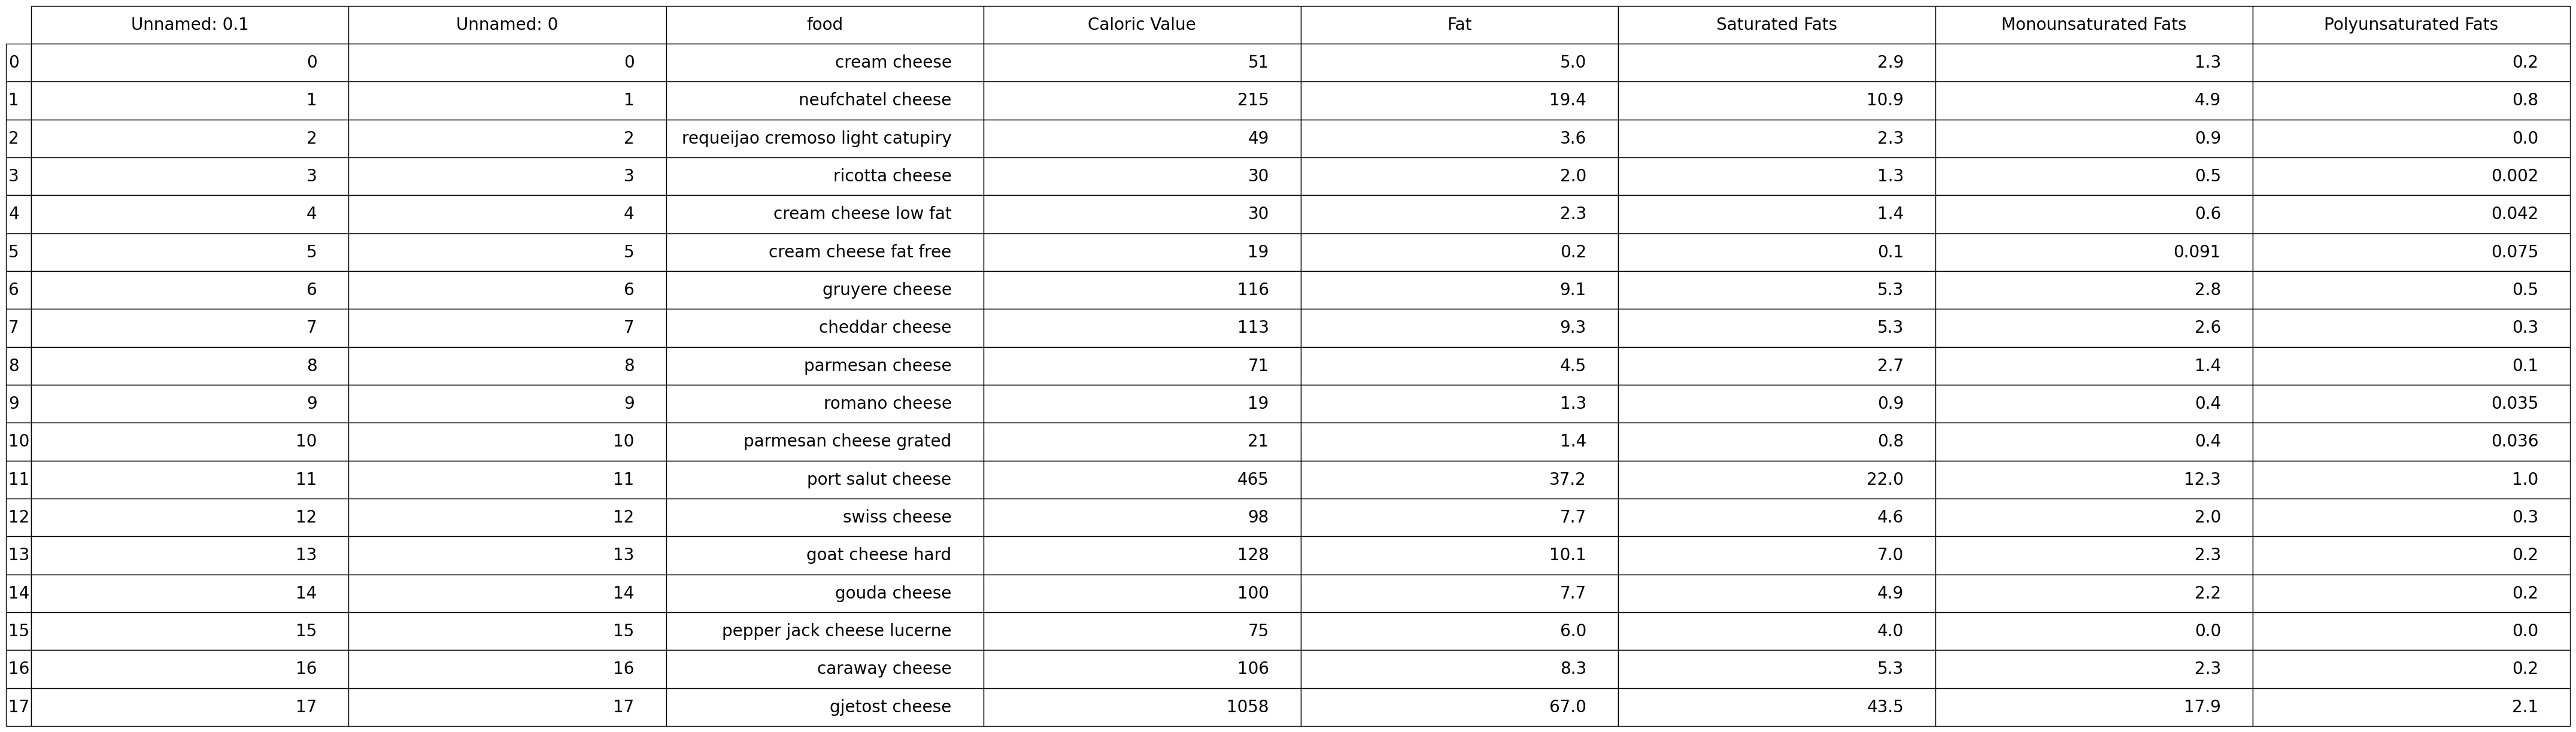

In [3]:
from pandas.plotting import table
# Select only the top 8 columns (this will select only the first 8 columns)
top_8_columns_df = df.iloc[:, :8]

# Get the top 18 rows of the data for better clarity
top_18_df = top_8_columns_df.head(18)

# Apply styling to the DataFrame
styled_df = top_18_df.style.set_table_styles(
    [{'selector': 'thead th', 'props': [('border', '2px solid black')]},  # Header border
     {'selector': 'tbody td', 'props': [('border', '1px solid black')]},   # Cell borders
     {'selector': 'table', 'props': [('border-collapse', 'collapse')]},  # Merge borders for the table
     {'selector': 'thead', 'props': [('background-color', '#f2f2f2')]}, # Light gray header background
     {'selector': 'tbody tr:nth-child(odd)', 'props': [('background-color', '#f9f9f9')]},  # Odd row background
     {'selector': 'tbody tr:nth-child(even)', 'props': [('background-color', '#ffffff')]},  # Even row background
    ])

# Convert the styled DataFrame to a matplotlib figure
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the size as needed

# Hide the axes and create the table
ax.axis('off')
tbl = table(ax, top_18_df, loc='center', colWidths=[0.15] * len(top_18_df.columns))  # Adjust column widths

# Style the table manually for a more polished look
tbl.auto_set_font_size(False)
tbl.set_fontsize(20)  # Set font size for better visibility
tbl.scale(3.8, 3.8)  # Adjust the scaling of the table
plt.show()

In [4]:
# Check the first few rows of the dataset
print(df.head())

# Get basic information about the data types and missing values
print(df.info())

# Describe the numerical features to get statistical summaries
print(df.describe())

# Check for missing data
missing_data = df.isnull().sum()
print(f"Missing Data:\n{missing_data[missing_data > 0]}")

   Unnamed: 0.1  Unnamed: 0                              food  Caloric Value  \
0             0           0                      cream cheese             51   
1             1           1                 neufchatel cheese            215   
2             2           2  requeijao cremoso light catupiry             49   
3             3           3                    ricotta cheese             30   
4             4           4              cream cheese low fat             30   

    Fat  Saturated Fats  Monounsaturated Fats  Polyunsaturated Fats  \
0   5.0             2.9                   1.3                 0.200   
1  19.4            10.9                   4.9                 0.800   
2   3.6             2.3                   0.9                 0.000   
3   2.0             1.3                   0.5                 0.002   
4   2.3             1.4                   0.6                 0.042   

   Carbohydrates  Sugars  ...  Calcium  Copper   Iron  Magnesium  Manganese  \
0            

Data Cleaning - Duplicates

In [5]:
# Remove duplicate rows if any
df.drop_duplicates(inplace=True)

# Verify duplicates are removed
df.duplicated().sum()

0

Feature Exploration

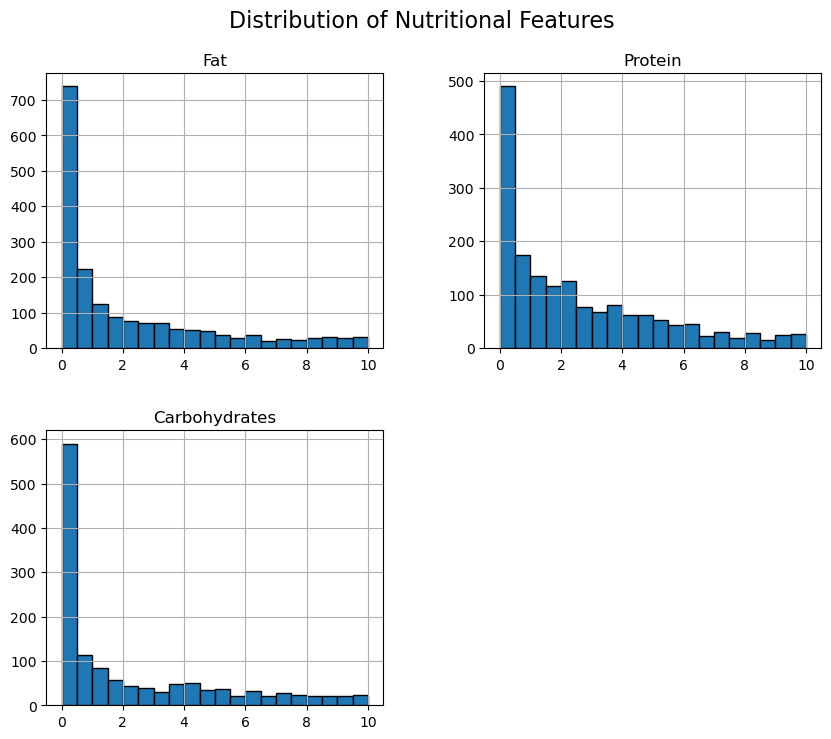

In [6]:
import matplotlib.pyplot as plt

# Check the distribution of nutritional features with a smaller range and specific bins
df[['Fat', 'Protein', 'Carbohydrates']].hist(
    bins=20, 
    figsize=(10, 8), 
    edgecolor='black', 
    range=(0, 10)  # Set a smaller range for the x-axis
)

# Add a main title and labels for clarity
plt.suptitle('Distribution of Nutritional Features', fontsize=16)
plt.subplots_adjust(top=0.9)  # Adjust space for the title

# Label the x and y axes for all subplots
plt.xlabel('Grams', fontsize=12)  # X-axis label (Grams)
plt.ylabel('Frequency', fontsize=12)  # Y-axis label (Frequency)

# Display the plot
plt.show()


Detecting Outliers

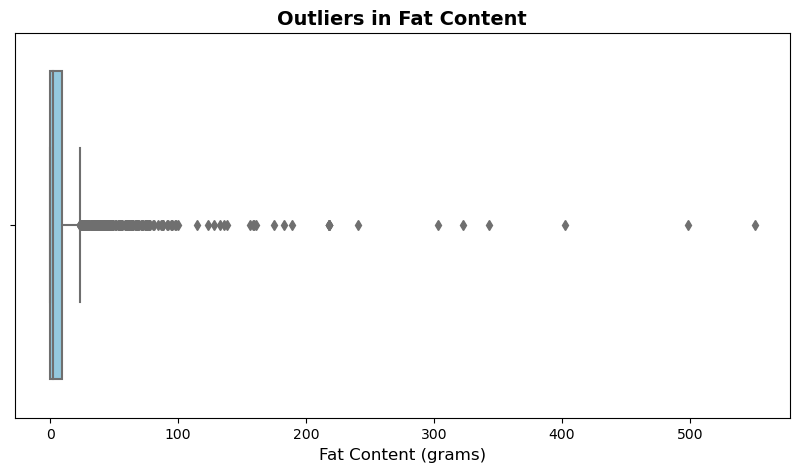

Total Outliers Detected: 241
                       food   Fat
11        port salut cheese  37.2
17           gjetost cheese  67.0
21           asadero cheese  31.9
24         roquefort cheese  26.0
25      queso blanco cheese  28.7
...                     ...   ...
2050         bacon meatless  42.5
2080            soybean raw  37.1
2273                avocado  39.6
2366   taco salad taco bell  48.9
2369  potato salad with egg  23.5

[241 rows x 2 columns]


In [33]:
# Define IQR (Interquartile Range) to detect outliers
Q1 = df['Fat'].quantile(0.25)  # 25th percentile
Q3 = df['Fat'].quantile(0.75)  # 75th percentile
IQR = Q3 - Q1  # Interquartile range

# Set threshold for detecting outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['Fat'] < lower_bound) | (df['Fat'] > upper_bound)]

# Create a boxplot with clear labels
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['Fat'], color='skyblue')

# Add title and labels
plt.title("Outliers in Fat Content", fontsize=14, fontweight='bold')
plt.xlabel("Fat Content (grams)", fontsize=12)
plt.xticks(fontsize=10)

# Show the plot
plt.show()

# Print the outliers for reference
print(f"Total Outliers Detected: {len(outliers)}")
print(outliers[['food', 'Fat']])  # Display food names and fat content for context

Define Features and Target Variable

In [34]:
# Define features and target variable
X = df[['Fat', 'Protein', 'Carbohydrates']]
y = df['Caloric Value']


Split Data into Training and Test Sets

In [35]:
# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Train a Linear Regression Model

In [36]:
# Train a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on test set
y_pred_lr = lr_model.predict(X_test)

# Evaluate performance
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
lr_r2 = r2_score(y_test, y_pred_lr)

print(f'Linear Regression RMSE: {lr_rmse:.2f}')
print(f'Linear Regression R2: {lr_r2:.2f}')

Linear Regression RMSE: 0.00
Linear Regression R2: 1.00


In [37]:
# Calculate the expected caloric value using the formula
df['Calculated_Caloric_Value'] = 9 * df['Fat'] + 4 * df['Carbohydrates'] + 4 * df['Protein']

# Compare the calculated caloric value with the existing caloric value
df['Caloric_Value_Difference'] = df['Caloric Value'] - df['Calculated_Caloric_Value']

# Check for discrepancies
discrepancies = df[df['Caloric_Value_Difference'] != 0]
print("Rows with discrepancies:")
print(discrepancies)


# If discrepancies are found, you can correct the 'Caloric Value' column
df['Caloric Value'] = df['Calculated_Caloric_Value']

# Drop the temporary columns if no longer needed
df.drop(columns=['Calculated_Caloric_Value', 'Caloric_Value_Difference'], inplace=True)

# Now, retrain your models with the corrected data
X = df[['Fat', 'Protein', 'Carbohydrates']]
y = df['Caloric Value']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on test set
y_pred_lr = lr_model.predict(X_test)

# Evaluate performance
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
lr_r2 = r2_score(y_test, y_pred_lr)

print(f'Linear Regression RMSE: {lr_rmse:.2f}')
print(f'Linear Regression R2: {lr_r2:.2f}')

Rows with discrepancies:
Empty DataFrame
Columns: [Unnamed: 0.1, Unnamed: 0, food, Caloric Value, Fat, Saturated Fats, Monounsaturated Fats, Polyunsaturated Fats, Carbohydrates, Sugars, Protein, Dietary Fiber, Cholesterol, Sodium, Water, Vitamin A, Vitamin B1, Vitamin B11, Vitamin B12, Vitamin B2, Vitamin B3, Vitamin B5, Vitamin B6, Vitamin C, Vitamin D, Vitamin E, Vitamin K, Calcium, Copper, Iron, Magnesium, Manganese, Phosphorus, Potassium, Selenium, Zinc, Nutrition Density, Calculated_Caloric_Value, Caloric_Value_Difference]
Index: []

[0 rows x 39 columns]
Linear Regression RMSE: 0.00
Linear Regression R2: 1.00


Train a Decision Tree Regressor Model

In [38]:
# Train a Decision Tree model
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Predict on test set
y_pred_dt = dt_model.predict(X_test)

# Evaluate performance
dt_rmse = np.sqrt(mean_squared_error(y_test, y_pred_dt))
dt_r2 = r2_score(y_test, y_pred_dt)

print(f'Decision Tree RMSE: {dt_rmse:.2f}')
print(f'Decision Tree R2: {dt_r2:.2f}')

Decision Tree RMSE: 128.68
Decision Tree R2: 0.92


Train a Random Forest Regressor Model

In [39]:
X = df[['Fat', 'Protein', 'Carbohydrates']]
y = df['Caloric Value']

rf_model = RandomForestRegressor(
    n_estimators=100,       # Fewer trees to simplify the model
    max_depth=10,           # Shallower trees
    min_samples_split=20,   # Require more samples to split a node
    min_samples_leaf=10,    # Require more samples at leaf nodes
    max_features='log2',    # Consider fewer features at each split
    bootstrap=True,         # Use bootstrapping for added randomness
    random_state=42,
    n_jobs=-1
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # Scale X_train
X_test_scaled = scaler.transform(X_test)       # Scale X_test using the same scaler

# Train the model
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate Performance
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_r2 = r2_score(y_test, y_pred_rf)

print(f"Random Forest RMSE: {rf_rmse:.2f}")
print(f"Random Forest R2: {rf_r2:.2f}")


Random Forest RMSE: 191.34
Random Forest R2: 0.82


Model Comparison - RMSE

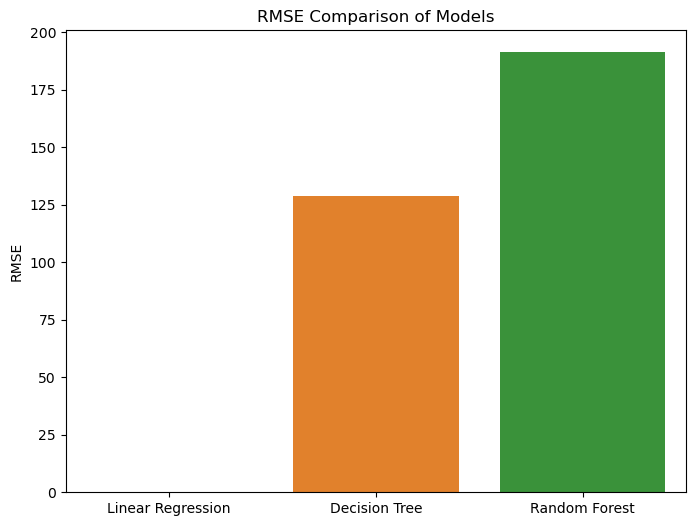

In [40]:
# Compare RMSE of all models
models_rmse = {
    'Linear Regression': lr_rmse,
    'Decision Tree': dt_rmse,
    'Random Forest': rf_rmse
}

plt.figure(figsize=(8, 6))
sns.barplot(x=list(models_rmse.keys()), y=list(models_rmse.values()))
plt.title('RMSE Comparison of Models')
plt.ylabel('RMSE')
plt.show()

Model Comparison - R2 Score

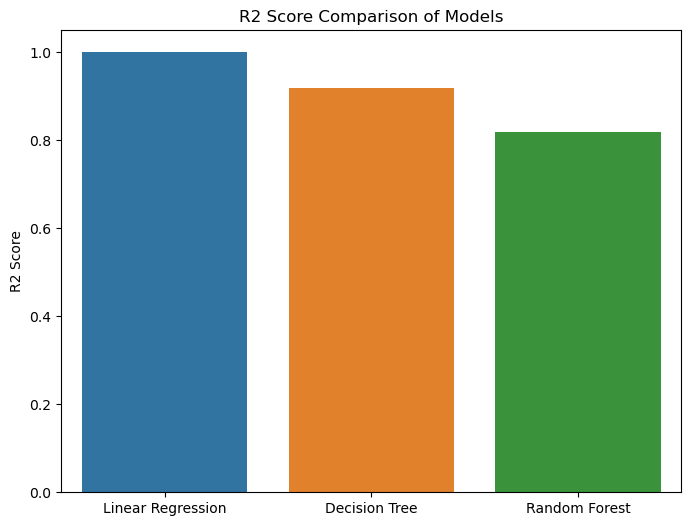

In [41]:
# Compare R2 score of all models
models_r2 = {
    'Linear Regression': lr_r2,
    'Decision Tree': dt_r2,
    'Random Forest': rf_r2
}

plt.figure(figsize=(8, 6))
sns.barplot(x=list(models_r2.keys()), y=list(models_r2.values()))
plt.title('R2 Score Comparison of Models')
plt.ylabel('R2 Score')
plt.show()

Cross-Validation for Random Forest

In [42]:
# Perform cross-validation for Random Forest model
rf_cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='neg_mean_squared_error')

# Calculate RMSE for each fold
rf_cv_rmse = np.sqrt(-rf_cv_scores)

print(f'Cross-Validation RMSE for Random Forest: {rf_cv_rmse}')
print(f'Average CV RMSE: {rf_cv_rmse.mean():.2f}')

Cross-Validation RMSE for Random Forest: [ 53.86686776 100.23547103 375.1718142  162.36631652  24.15212305]
Average CV RMSE: 143.16


Feature Importance in Random Forest

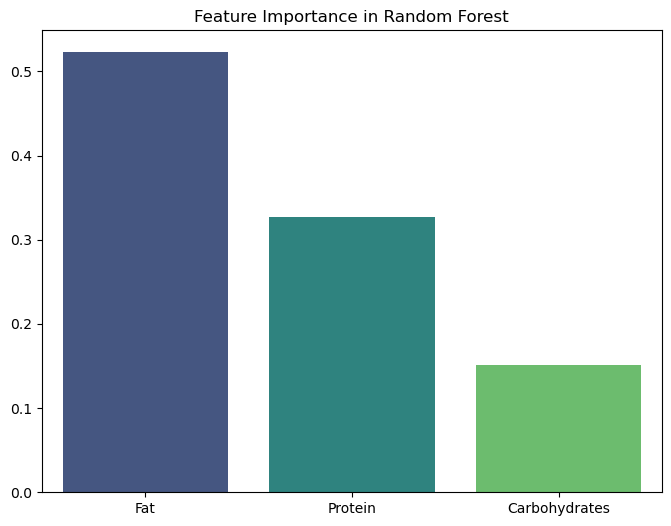

In [43]:
# Get feature importance from Random Forest model
feature_importance = rf_model.feature_importances_

# Visualize the feature importance
plt.figure(figsize=(8, 6))
# Ensure feature_importance is sliced to the same length as x
sns.barplot(x=['Fat', 'Protein', 'Carbohydrates'], y=feature_importance[:3], palette='viridis')
plt.title('Feature Importance in Random Forest')
plt.show()

Save the Trained Model

In [44]:
# Save the trained Random Forest model
joblib.dump(rf_model, 'food_nutritional_model_rf.pkl')

['food_nutritional_model_rf.pkl']

Save Scaler

In [45]:
# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

Load the Saved Model

In [46]:
# Load the trained Random Forest model
loaded_rf_model = joblib.load('food_nutritional_model_rf.pkl')

# Make predictions using the loaded model
y_pred_loaded = loaded_rf_model.predict(X_test.values)

Learning Curve for Random Forest

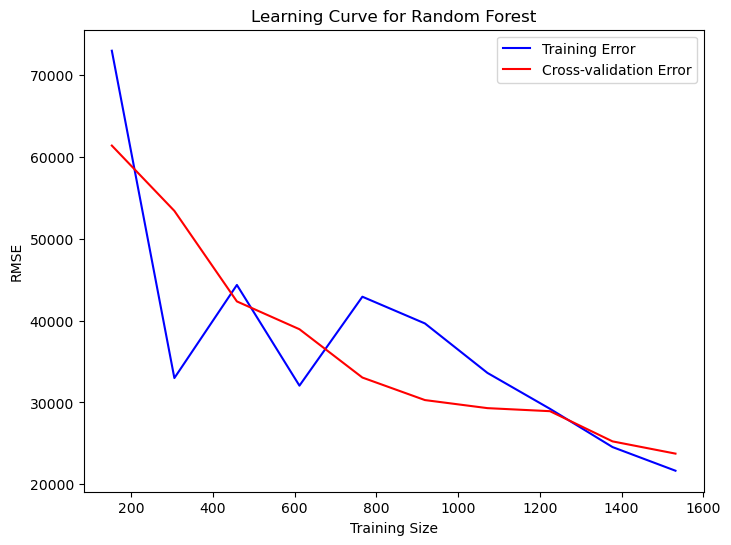

In [47]:
# Plot learning curve for Random Forest model
train_sizes, train_scores, test_scores = learning_curve(
    estimator=rf_model,
    X=X_train,
    y=y_train,
    cv=5,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate average training and test scores
train_mean = np.mean(-train_scores, axis=1)
test_mean = np.mean(-test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='Training Error', color='blue')
plt.plot(train_sizes, test_mean, label='Cross-validation Error', color='red')
plt.title('Learning Curve for Random Forest')
plt.xlabel('Training Size')
plt.ylabel('RMSE')
plt.legend()
plt.show()

Residual Plot for Random Forest

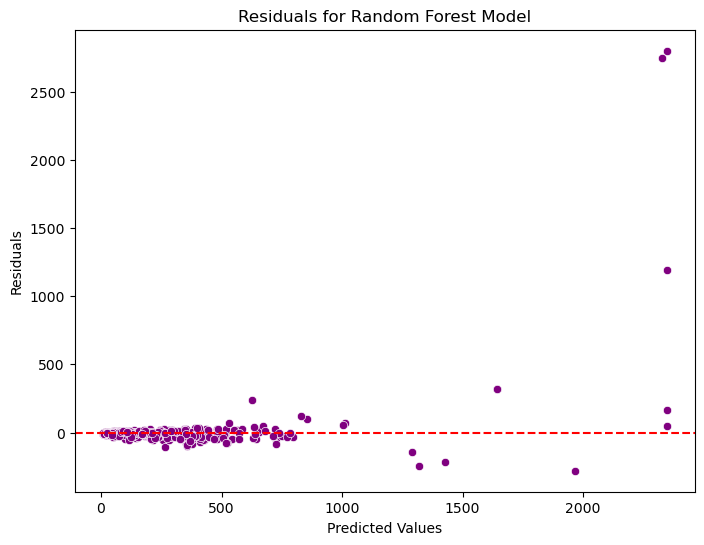

In [48]:
# Plot residuals for Random Forest model
residuals = y_test - y_pred_rf

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_rf, y=residuals, color='purple')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals for Random Forest Model')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

Evaluating Multicollinearity with VIF (Variance Inflation Factor)

In [49]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Add constant to X (for VIF calculation)
X_with_const = add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X_with_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

# Display VIF values
print(vif_data)

         Feature       VIF
0          const  1.592146
1            Fat  1.567893
2        Protein  1.567439
3  Carbohydrates  1.002738


Feature Scaling (Standardization)

In [50]:
# Standardize the features for better model performance
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[['Fat', 'Protein', 'Carbohydrates', 'Caloric Value']])

# Verify scaling by checking mean and standard deviation
print('Mean after scaling:', df_scaled.mean(axis=0))
print('Standard deviation after scaling:', df_scaled.std(axis=0))

Mean after scaling: [ 1.18671021e-17 -3.56013062e-17 -1.30538123e-16  0.00000000e+00]
Standard deviation after scaling: [1. 1. 1. 1.]


Train a Support Vector Machine Model

In [51]:
from sklearn.svm import SVR

# Train a Support Vector Machine model
svm_model = SVR(kernel='rbf')
svm_model.fit(X_train, y_train)

# Predict using the SVM model
y_pred_svm = svm_model.predict(X_test)

# Evaluate performance of SVM model
svm_rmse = np.sqrt(mean_squared_error(y_test, y_pred_svm))
svm_r2 = r2_score(y_test, y_pred_svm)

print(f'Support Vector Machine RMSE: {svm_rmse:.2f}')
print(f'Support Vector Machine R2: {svm_r2:.2f}')

Support Vector Machine RMSE: 406.16
Support Vector Machine R2: 0.19


Visualizing Model Performance with Prediction vs Actual Plot

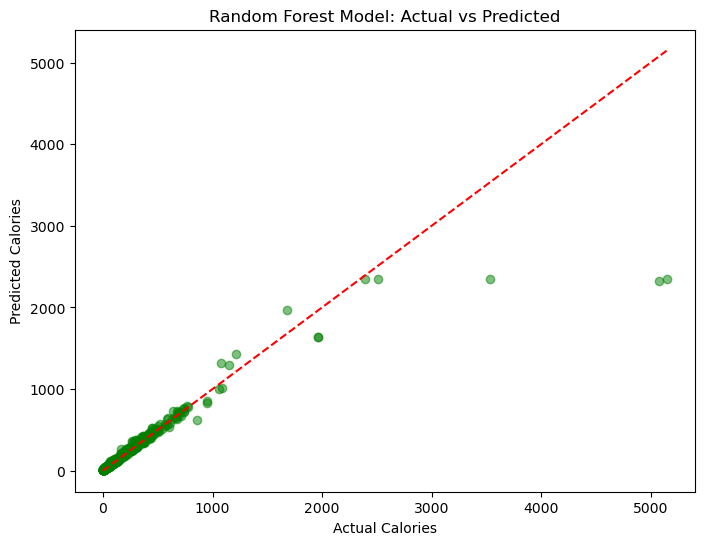

In [52]:
# Plot Actual vs Predicted values for Random Forest
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, color='green', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Random Forest Model: Actual vs Predicted')
plt.xlabel('Actual Calories')
plt.ylabel('Predicted Calories')
plt.show()

Evaluate Model with Additional Metrics (MAE, RMSE, and R2)

In [53]:
from sklearn.metrics import mean_absolute_error

# Calculate additional metrics for Random Forest model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Mean Absolute Error (MAE): {mae_rf:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_rf:.2f}')
print(f'R2 Score: {r2_rf:.2f}')

Mean Absolute Error (MAE): 33.35
Root Mean Squared Error (RMSE): 191.34
R2 Score: 0.82


--------------------------------------------------------------------

Updated Calculation

------------------------------------------

---------------------------------

Calculate the Expected Caloric Value

In [54]:
# Calculate the expected caloric value using the formula
df['Calculated_Caloric_Value'] = 9 * df['Fat'] + 4 * df['Carbohydrates'] + 4 * df['Protein']

# Compare the calculated caloric value with the existing caloric value
df['Caloric_Value_Difference'] = df['Caloric Value'] - df['Calculated_Caloric_Value']

# Check for discrepancies
discrepancies = df[df['Caloric_Value_Difference'] != 0]
print("Rows with discrepancies:")
print(discrepancies)

# If discrepancies are found, correct the 'Caloric Value' column
df['Caloric Value'] = df['Calculated_Caloric_Value']

# Drop the temporary columns if no longer needed
df.drop(columns=['Calculated_Caloric_Value', 'Caloric_Value_Difference'], inplace=True)

Rows with discrepancies:
Empty DataFrame
Columns: [Unnamed: 0.1, Unnamed: 0, food, Caloric Value, Fat, Saturated Fats, Monounsaturated Fats, Polyunsaturated Fats, Carbohydrates, Sugars, Protein, Dietary Fiber, Cholesterol, Sodium, Water, Vitamin A, Vitamin B1, Vitamin B11, Vitamin B12, Vitamin B2, Vitamin B3, Vitamin B5, Vitamin B6, Vitamin C, Vitamin D, Vitamin E, Vitamin K, Calcium, Copper, Iron, Magnesium, Manganese, Phosphorus, Potassium, Selenium, Zinc, Nutrition Density, Calculated_Caloric_Value, Caloric_Value_Difference]
Index: []

[0 rows x 39 columns]


 Retrain the Models

In [55]:
# Define features and target variable
X = df[['Fat', 'Protein', 'Carbohydrates']]
y = df['Caloric Value']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on test set
y_pred_lr = lr_model.predict(X_test)

# Evaluate performance
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
lr_r2 = r2_score(y_test, y_pred_lr)

print(f'Linear Regression RMSE: {lr_rmse:.2f}')
print(f'Linear Regression R2: {lr_r2:.2f}')

# Train a Decision Tree model
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Predict on test set
y_pred_dt = dt_model.predict(X_test)

# Evaluate performance
dt_rmse = np.sqrt(mean_squared_error(y_test, y_pred_dt))
dt_r2 = r2_score(y_test, y_pred_dt)

print(f'Decision Tree RMSE: {dt_rmse:.2f}')
print(f'Decision Tree R2: {dt_r2:.2f}')

# Train a Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,       # Fewer trees to simplify the model
    max_depth=10,           # Shallower trees
    min_samples_split=20,   # Require more samples to split a node
    min_samples_leaf=10,    # Require more samples at leaf nodes
    max_features='log2',    # Consider fewer features at each split
    bootstrap=True,         # Use bootstrapping for added randomness
    random_state=42,
    n_jobs=-1
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # Scale X_train
X_test_scaled = scaler.transform(X_test)       # Scale X_test using the same scaler

# Train the model
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate Performance
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_r2 = r2_score(y_test, y_pred_rf)

print(f"Random Forest RMSE: {rf_rmse:.2f}")
print(f"Random Forest R2: {rf_r2:.2f}")

Linear Regression RMSE: 0.00
Linear Regression R2: 1.00
Decision Tree RMSE: 128.68
Decision Tree R2: 0.92
Random Forest RMSE: 191.34
Random Forest R2: 0.82


In [56]:
# Save the corrected dataset to a new CSV file
df.to_csv('FOOD-DATA-CORRECTED.csv', index=False)